In [6]:
import time
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from skimage import img_as_float32
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Dense, Softmax
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from natsort import natsorted
import matplotlib.pyplot as plt
from glob import glob
import json
from functools import partial
import numpy as np
from cachier import cachier
from tqdm import tqdm
import imageio
import cv2 as cv2
from math import pi, e, sqrt, cos, sin
from scipy.stats import norm, multivariate_normal
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
import os
from collections import defaultdict
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [29]:
HYPER_PARAMS = {
                'MODEL_LEARN_EPOCHS' : 10,
                'MODEL_LEARN_RATE' : 1e-5,
                'BASE_IMAGE_SIZE' : (768, 1024),
                'SCALED_IMAGE_SIZE' : (192, 256),
                'CORNER_RECT_DIMS' : (10, 10),
                'MORPH_KERNEL_DIMS' : 5 # Morphological transformations kernel size
               }

In [8]:
ztqdm = partial(tqdm, position=0, leave=True)
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')

In [9]:
SIZE = (768, 1024)
NEW_SIZE = (256, 192)
DATA_PATH_PAIRS = list(zip(
    natsorted(glob(f'../data/images-{SIZE[1]}x{SIZE[0]}/*.png')),
    natsorted(glob(f'../data/masks-{SIZE[1]}x{SIZE[0]}/*.png')),
))
DATA_IMGS = np.array(
    [cv2.resize(img_as_float32(imageio.imread(img_path)), NEW_SIZE) 
     for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
DATA_MSKS = np.array(
    [cv2.resize(img_as_float32(imageio.imread(msk_path)), NEW_SIZE, interpolation = cv2.INTER_NEAREST) 
     for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])

Loading Masks: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 267.84it/s]


In [10]:
with open(f'../data/corners.json', mode='r') as f:
    DATA_CORNER_NAMES, DATA_CORNERS = json.load(f)
    DATA_CORNERS = np.array(DATA_CORNERS)

In [11]:
def normalise_data(data):
    return np.subtract(data, np.min(data))/ np.subtract(np.max(data), np.min(data))

def show_image(image,cs=False,cmap= None, title=None):
    if cs:
        norm_img = normalise_data(image)
    else:
        norm_img = image
    plt.title(title)
    plt.imshow(norm_img, cmap= cmap)
    plt.xticks([])
    plt.yticks([])

In [12]:
def get_corner_targets(image_ratios, masks, indices):
    corner_targets = []
    index_count = 0
    for corner_ratios in image_ratios[indices]:
        corner_mask = masks[indices[index_count]].copy()
        for corner_ratio in corner_ratios:
            y = int(corner_ratio[1] * HYPER_PARAMS['SCALED_IMAGE_SIZE'][0])
            x = int(corner_ratio[0] * HYPER_PARAMS['SCALED_IMAGE_SIZE'][1])
            w =  HYPER_PARAMS['CORNER_RECT_DIMS'][0]
            h =  HYPER_PARAMS['CORNER_RECT_DIMS'][1]
            # Third class between 0 and 255
            corner_mask = cv2.rectangle(corner_mask, 
                                        (int(x - w / 2), int(y - h / 2)),
                                        (int(x + w / 2), int(y + h / 2)),
                                        (2, 2, 2), 
                                        -1)
                
        corner_targets.append(corner_mask)
        index_count += 1
    return np.array(corner_targets)
    
def train_test_split(images, masks, corner_ratios, train_size=0.7, validation_size=0.15, test_size=0.15):
    all_indices = np.arange(len(images))
    np.random.shuffle(all_indices)
    train_indices = all_indices[0: int(len(images)* train_size) + 1]
    validate_inidices = all_indices[len(train_indices): len(train_indices) + int(len(images)* validation_size)]
    test_indices = all_indices[len(train_indices)+len(validate_inidices): len(train_indices)+len(validate_inidices)+ int(len(images)* test_size)]

    train_images = np.array([images[i] for i in train_indices])
    train_masks = np.array([masks[i] for i in train_indices])
    train_masks_corners = get_corner_targets(corner_ratios, masks, train_indices)
        
    validate_images = np.array([images[i] for i in validate_inidices])
    validate_masks = np.array([masks[i] for i in validate_inidices])
    validate_masks_corners = get_corner_targets(corner_ratios, masks, validate_inidices)
        
    test_images = np.array([images[i] for i in test_indices])
    test_masks = np.array([masks[i] for i in test_indices])
    test_masks_corners = get_corner_targets(corner_ratios, masks, test_indices)
        
    return train_images, train_masks, train_masks_corners,\
           validate_images, validate_masks, validate_masks_corners,\
           test_images, test_masks, test_masks_corners


def get_augmented_lists(num_classes, image, mask, gaus=(3, 3)):
    """
    Returns RGB, Gaussian blurred, vertically flipped and horizontally flipped image
    and mask augmentations.
    """
        
    # RGB image
    image_list = [
        np.expand_dims(normalise_data(image.astype(np.float32)), axis=0)]
    mask_list = [
        tf.one_hot(
        np.expand_dims(mask.astype(np.int32), axis=0),
        depth=num_classes,
        dtype=tf.int32)]
        
    # Gaussian blurred image
    image_ = cv2.GaussianBlur(image, gaus, 0).astype(np.float32)  
    image_list.append(
        np.expand_dims(normalise_data(image_.astype(np.float32)), axis=0))
    mask_list.append(
                tf.one_hot(
                np.expand_dims(mask.astype(np.int32), axis=0),
                depth=num_classes,
                dtype=tf.int32)
                )
        
    # Vertical flip image 
    image_ = cv2.flip(image, 0)
    image_list.append(
        np.expand_dims(normalise_data(image_.astype(np.float32)), axis=0))
    mask_ = cv2.flip(mask, 0)
    mask_list.append(
                tf.one_hot(
                np.expand_dims(mask_.astype(np.int32), axis=0),
                depth=num_classes,
                dtype=tf.int32)
                )
        
    # Horizontal flip image
    image_ = cv2.flip(image, 1)
    image_list.append(
        np.expand_dims(normalise_data(image_.astype(np.float32)), axis=0))
    mask_ = cv2.flip(mask, 1)
    mask_list.append(
                tf.one_hot(
                np.expand_dims(mask_.astype(np.int32), axis=0),
                depth=num_classes,
                dtype=tf.int32)
                )
    return image_list, mask_list

# Train, validation and training split
Split data randomly into sets of 70% training, 15% validation and 15% testing

In [15]:
train_images, train_masks, train_masks_corners, \
validate_images, validate_masks, validate_masks_corners, \
test_images, test_masks, test_masks_corners = train_test_split(DATA_IMGS, DATA_MSKS, DATA_CORNERS,
                                                              train_size=0.7, validation_size=0.15, test_size=0.15)

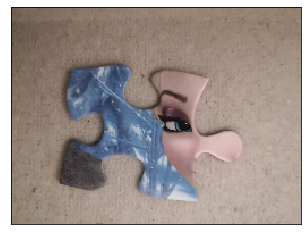

In [16]:
show_image(train_images[3])

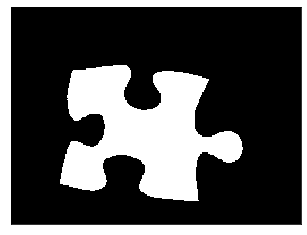

In [17]:
show_image(train_masks[3], cmap='gray')

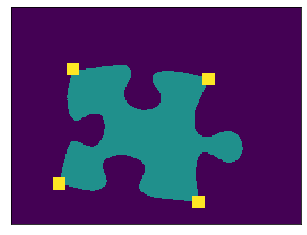

In [18]:
show_image(train_masks_corners[3])

# Pre-process data:
Create augmented training set (Includes pre-processing of images and masks)

In [20]:
def preprocess_image_data(train_images, train_masks, train_masks_corners,
                          validate_images, validate_masks, validate_masks_corners,
                          test_images=None, test_masks=None, test_masks_corners=None, num_classes=3):
    """Apply augmentation to training set, and one hot encode masks for model training and predictions"""

    augmented_data = []
    augmented_masks = []
    validate_images_ = []
    validate_masks_ = []
    test_images_ = []
    test_masks_ = []
    
    if num_classes == 3:
        train_masks = train_masks_corners
        validate_masks = validate_masks_corners
    
    # Augmented training data
    for train_image, train_mask in zip(train_images, train_masks):
        image_list, mask_list = get_augmented_lists(num_classes, train_image, train_mask)
        augmented_data += image_list
        augmented_masks += mask_list
    
    # Validation data
    for validate_image, validate_mask in zip(validate_images, validate_masks):
        validate_images_.append(np.expand_dims(normalise_data(validate_image), axis=0))
        validate_masks_.append(
                                tf.one_hot(
                                np.expand_dims(validate_mask.astype(np.int32), axis=0),
                                depth=num_classes,
                                dtype=tf.int32))
    # Optional testing data
    if test_images is not None:
        for test_image, test_mask in zip(test_images, test_masks):
            test_images_.append(np.expand_dims(normalise_data(test_image), axis=0))
            test_masks_.append(test_mask)
    
    # Create tf dataset
    training_data = tf.data.Dataset.from_tensor_slices((
        {
            'input_image': augmented_data
        },
        {
            'output_mask': augmented_masks
        }))

    validation_data = tf.data.Dataset.from_tensor_slices((
        {
            'input_image': validate_images_
        },
        {
            'output_mask': validate_masks_
        }))    
        
    return training_data, validation_data, test_images_, test_masks_

## VGG-16

The VGG16 model proposed was tested using the ImageNet data set, which contains over 15 million hand labeled high-resolution images, that belong to around 22-thousand categories. The model was trained for weeks, and pre-trained models are commonly available using deep learning APIs.

In [21]:
vgg16_pretrained = VGG16(include_top=False, weights='imagenet', input_shape=(192,256,3))
vgg16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)       0     

## The U-Net architecture
U-Net was originally published as a convolutional network for biomedical image segmentation. The U-Net model was named after its U-shape that consists of two paths, which are commonly referred to in deep learning as the encoder- and decoder networks. U-Net's encoder captures the context of input images, and it contains a symmetric decoder that allows to localization using a technique called upsampling (fractional convolution or transposed convolution.)
<br><br>
![Unet](resources/Unet.PNG)


### VGG16-U-Net
The idea is to use the pre-trained VGG16 model as the encoder to a U-Net model, and also to construct a symmetric decoder network.

In [32]:
class VGGUnet(object):
    
    def __init__(self, input_shape=(192, 256, 3), num_classes=3, learning_rate=1e-4):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model(self.input_shape, self.num_classes)
        self.optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
    def _build_model(self, input_shape, num_classes):
        """Builds a UNet model from Keras' pretrained VGG16 model."""
        encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
        encoder.layers[0]._name  = 'input_image'
        # Decoder block1, from Encoder output
        encoder_output = encoder.output
        conv_0 = Conv2D(512, 3, activation='relu', padding='same')(encoder_output)
        conv_0_up = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_0)
        
        # Decoder block 1, concat block with encoder block 5
        concat_1 = concatenate([encoder.get_layer('block5_conv3').output, conv_0_up])
        conv_1 = Conv2D(512, 3, activation='relu', padding='same')(concat_1)
        conv_1_up =  Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_1)
        
        # Decoder block 2, concat block with encoder block 4
        concat_2 = concatenate([encoder.get_layer('block4_conv3').output, conv_1_up])
        conv_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_2)
        conv_2_up =  Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_2)
        
        # Decoder block 3, concat block with encoder block 3
        concat_3 = concatenate([encoder.get_layer('block3_conv3').output, conv_2_up])
        conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_3)
        conv_3_up =  Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(conv_3)
        
        # Decoder block 4, concat block with encoder block 2
        concat_4 = concatenate([encoder.get_layer('block2_conv2').output, conv_3_up])
        conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_4)
        conv_4_up =  Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(conv_4)
        
        # Decoder block 5, concat block with encoder block 1
        concat_5 = concatenate([encoder.get_layer('block1_conv2').output, conv_4_up])
        conv_5 = Conv2D(32, 3, activation='relu', padding='same')(concat_5)
        
        outputs = Conv2D(num_classes, 1, activation='softmax', name='output_mask')(conv_5)
        
        return Model(inputs=encoder.layers[0].input, outputs=outputs, name='VGGUNet')
    
    def summary(self):
        print(self.model.summary())

    def train(self, training_data, validation_data, epochs):
        self.model.fit(training_data, validation_data=validation_data, epochs=epochs)
    
    def predict(self, X):
        return np.squeeze(self.model.predict(X))

def post_processing(fg_bg_pred, kernel_dims):
    """Apply morhpolical transformations of closing
    and opening"""
    kernel = np.ones((kernel_dims, kernel_dims),np.uint8)
    fg_bg_pred = cv2.morphologyEx(fg_bg_pred, cv2.MORPH_OPEN, kernel)
    fg_bg_pred = cv2.morphologyEx(fg_bg_pred, cv2.MORPH_CLOSE, kernel)
    return fg_bg_pred

def set_corner_segmentation(fg_bg_pred, corner_pred):
    result = fg_bg_pred.copy()
    corner_pred = (corner_pred > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(corner_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = np.array([cv2.contourArea(contour) for contour in contours])
    # Draw a centered rectangle for the 4 largest contour areas
    for index in areas.argsort()[-4:][::-1]:
        x, y, w, h = cv2.boundingRect(contours[index])
        result = cv2.rectangle(result.astype(np.float32), (x, y),
                              (x + HYPER_PARAMS['CORNER_RECT_DIMS'][0],
                               y + HYPER_PARAMS['CORNER_RECT_DIMS'][1]), 2, -1)
    return result
        
def test_predictions(num_classes, vgg_unet, test_images, test_masks, morph_dims, plot=True):
    predict_count = 0
    total_score = 0
    for image, mask in zip(test_images, test_masks) :
        predict_count += 1
        pred = vgg_unet.predict(image)
        fg_bg_pred = pred[:, :, 0:2]
        fg_bg_pred = np.argmax(fg_bg_pred, axis=-1).astype(np.float32)
        fg_bg_pred = post_processing(fg_bg_pred, morph_dims)
        score = accuracy_score(fg_bg_pred.flatten(), mask.flatten().round())
        if num_classes == 3:
            corner_pred = pred[:, :, 2]
            final_image = set_corner_segmentation(fg_bg_pred, corner_pred)
        else:
            final_image = fg_bg_pred
        print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        total_score += score
        if plot:
            show_image(final_image)
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )  

In [23]:
vgg_unet = VGGUnet(learning_rate=HYPER_PARAMS['MODEL_LEARN_RATE'])

In [24]:
vgg_unet.summary()

Model: "VGGUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_image[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

# Background, Foreground and Corner Segmentation

This 3-class prediction produces slightly lower accuracy for background and foreground classification, <br>
hence a 2-class model is additionaly implemented, for a final accuracy to compare with the GMM.


### Training

In [38]:
NUM_CLASSES = 3

In [25]:
training_data, validation_data, test_images_, test_masks_ = preprocess_image_data(
                                                            train_images, train_masks, train_masks_corners,\
                                                            validate_images, validate_masks, validate_masks_corners,\
                                                            test_images, test_masks, test_masks_corners,
                                                            num_classes = NUM_CLASSES)

In [26]:
vgg_unet = VGGUnet(learning_rate=HYPER_PARAMS['MODEL_LEARN_RATE'],
                   num_classes = NUM_CLASSES)

In [27]:
vgg_unet.train(training_data, validation_data, epochs=HYPER_PARAMS['MODEL_LEARN_EPOCHS'])

Epoch 1/10
136/136 [==============================] - 153s 1s/step - loss: 0.4700 - accuracy: 0.7316 - val_loss: 0.1925 - val_accuracy: 0.8919
Epoch 2/10
136/136 [==============================] - 162s 1s/step - loss: 0.1000 - accuracy: 0.9471 - val_loss: 0.0689 - val_accuracy: 0.9657
Epoch 3/10
136/136 [==============================] - 160s 1s/step - loss: 0.0552 - accuracy: 0.9729 - val_loss: 0.0472 - val_accuracy: 0.9760
Epoch 4/10
136/136 [==============================] - 161s 1s/step - loss: 0.0424 - accuracy: 0.9777 - val_loss: 0.0387 - val_accuracy: 0.9785
Epoch 5/10
136/136 [==============================] - 161s 1s/step - loss: 0.0337 - accuracy: 0.9805 - val_loss: 0.0312 - val_accuracy: 0.9814
Epoch 6/10
136/136 [==============================] - 167s 1s/step - loss: 0.0262 - accuracy: 0.9841 - val_loss: 0.0293 - val_accuracy: 0.9831
Epoch 7/10
136/136 [==============================] - 170s 1s/step - loss: 0.0225 - accuracy: 0.9863 - val_loss: 0.0255 - val_accuracy: 0.9848

### Test predictions

Prediction #1, accuracy:98.95%


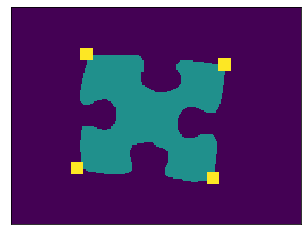

Prediction #2, accuracy:98.55%


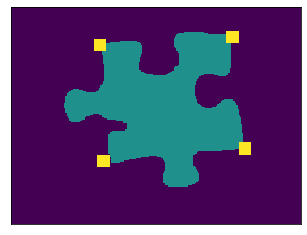

Prediction #3, accuracy:99.2%


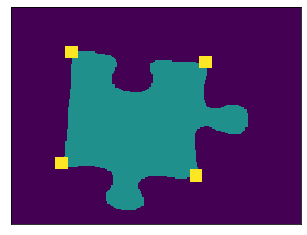

Prediction #4, accuracy:98.9%


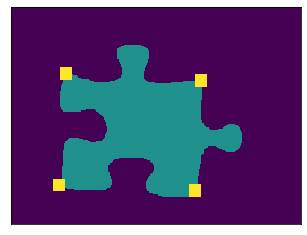

Prediction #5, accuracy:98.91%


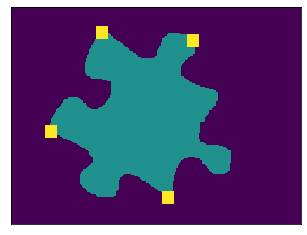

Prediction #6, accuracy:99.01%


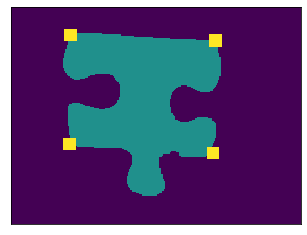

Prediction #7, accuracy:98.75%


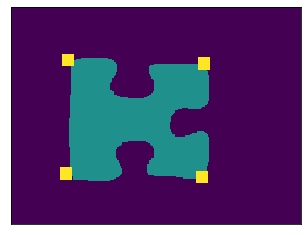

Average accuracy:98.9%


In [39]:
test_predictions(NUM_CLASSES, vgg_unet, test_images_, test_masks_, HYPER_PARAMS['MORPH_KERNEL_DIMS'])

# Background and Foreground
This 2-class prediction produces improved accuracy for background and foreground classification.

### Training

In [40]:
NUM_CLASSES = 2

In [41]:
training_data, validation_data, test_images_, test_masks_ = preprocess_image_data(
                                                            train_images, train_masks, train_masks_corners,\
                                                            validate_images, validate_masks, validate_masks_corners,\
                                                            test_images, test_masks, test_masks_corners,
                                                            num_classes = NUM_CLASSES)

In [42]:
vgg_unet = VGGUnet(learning_rate=HYPER_PARAMS['MODEL_LEARN_RATE'],
                   num_classes = NUM_CLASSES)

In [43]:
vgg_unet.train(training_data, validation_data, epochs=HYPER_PARAMS['MODEL_LEARN_EPOCHS'])

Epoch 1/10
136/136 [==============================] - 165s 1s/step - loss: 0.4411 - accuracy: 0.7918 - val_loss: 0.1608 - val_accuracy: 0.9363
Epoch 2/10
136/136 [==============================] - 170s 1s/step - loss: 0.0884 - accuracy: 0.9646 - val_loss: 0.0445 - val_accuracy: 0.9821
Epoch 3/10
136/136 [==============================] - 175s 1s/step - loss: 0.0413 - accuracy: 0.9837 - val_loss: 0.0330 - val_accuracy: 0.9863
Epoch 4/10
136/136 [==============================] - 178s 1s/step - loss: 0.0296 - accuracy: 0.9882 - val_loss: 0.0287 - val_accuracy: 0.9882
Epoch 5/10
136/136 [==============================] - 182s 1s/step - loss: 0.0241 - accuracy: 0.9903 - val_loss: 0.0262 - val_accuracy: 0.9894
Epoch 6/10
136/136 [==============================] - 181s 1s/step - loss: 0.0204 - accuracy: 0.9917 - val_loss: 0.0242 - val_accuracy: 0.9903
Epoch 7/10
136/136 [==============================] - 177s 1s/step - loss: 0.0179 - accuracy: 0.9926 - val_loss: 0.0237 - val_accuracy: 0.9907

### Test predictions

Prediction #1, accuracy:99.18%


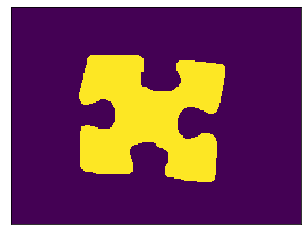

Prediction #2, accuracy:99.14%


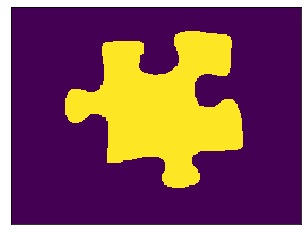

Prediction #3, accuracy:99.36%


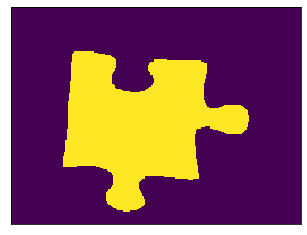

Prediction #4, accuracy:99.12%


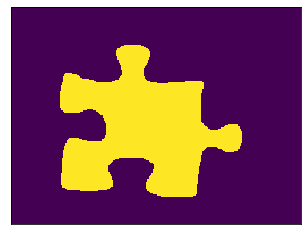

Prediction #5, accuracy:98.98%


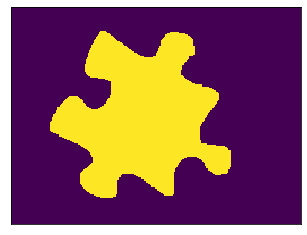

Prediction #6, accuracy:99.08%


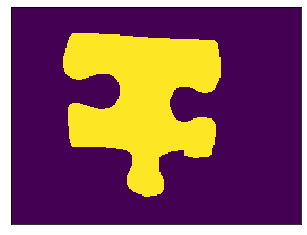

Prediction #7, accuracy:99.17%


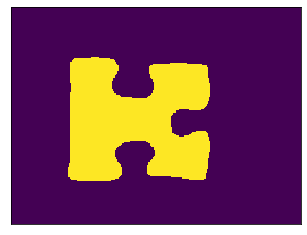

Average accuracy:99.15%


In [44]:
test_predictions(NUM_CLASSES, vgg_unet, test_images_, test_masks_, HYPER_PARAMS['MORPH_KERNEL_DIMS'])

## 6-Fold Cross-Validation
Since the data set is limited, cross-validation might be used to evaluate the skill of the GMM for the unseen test data. A 6-Fold method is used, which splits the data into 6 groups of 8 puzzle pieces each. The method is popular since it results in a less biased estimate of the model's skill than other methods. The procedure used follows:
- Shuffle the test set data randomly
- Split the data set randomly into the 6 groups (with 8 image data each.)
- Then for each of these groups
 - Assign the group as a test set
 - Use all the remaining groups as the training set
 - Fit the model on the training set and evaluate it using the test set
 - Compute the score and discard the model
- Model performance is then the mean value of all scores